<a href="https://colab.research.google.com/github/done-n-dusted/deblur-fashionmnist/blob/master/Denoising_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **De-Noising a Gaussian Blurred Image**

---

## **Aim**
De-noise a blurred given image using a Deep Learning methods of Machine Learning like Convolutional Neural Networks.

The motivation behind creating this program is to learn the use of auto-encoders. The program is loosely based on guided project from Coursera(https://www.coursera.org/projects/autoencoders-image-denoising) taught by Ryan Ahmed.

**Steps Involved**
1. Load the data set
2. Take the training set and blur the images.
3. Create a CNN model.
4. Train the model using the blurred images as an input and the original images as the ground truth.
5. Test the model.

In [ ]:
#importing few of the required packagaes
from keras import datasets
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

Using TensorFlow backend.


**Step 1** Loading the data set.

The dataset taken is the FashionMNIST dataset which is already included in the TensorFlow package.

Each image is a grayscale and of size 28 x 28.

In [ ]:
#loading the dataset
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()
X_train, X_test = X_train/255, X_test/255

4423680/4422102 [==============================] - 2s 1us/step


Plotting few images from the dataset to look at what kind of images the dataset possess.

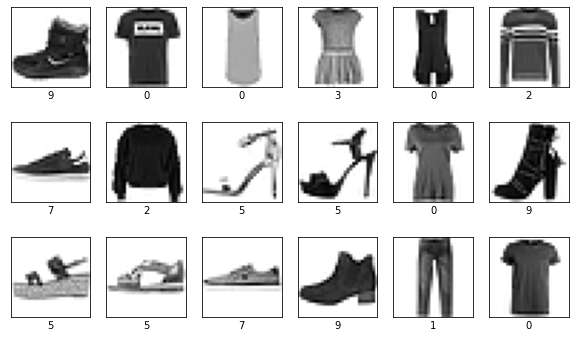

In [ ]:
class_names = list(range(10))
plt.figure(figsize=(10,6))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i]])
plt.show()

**Step 2** Adding noise to the dataset

Artificial Noise must be added to create the required data set for training the model. The following is the function that Gaussian Blurs all the images in the dataset with a kernel of size 3 x 3 following Gaussian Distribution.

In [ ]:
def add_noise(X):
    result = []
    for img in X:
        noisy = cv2.GaussianBlur(img, (3, 3), 0)
        noisy = np.clip(noisy, 0, 1)
        result.append(noisy)
    return np.array(result)

In [ ]:
noise_train = add_noise(X_train)
noise_test = add_noise(X_test)

Plotting the blurred dataset to understand the dataset.

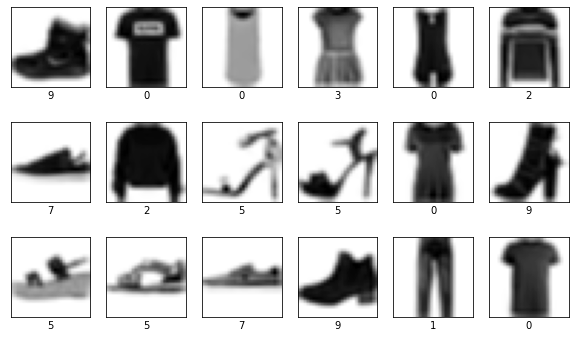

In [ ]:
class_names = list(range(10))
plt.figure(figsize=(10,6))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noise_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i]])
plt.show()

**Step 3** Building a CNN Model

The model follows an architecture shown in the flow chart below.

![](https://drive.google.com/uc?export=uc&id=1WhcxIgAFjKWLQZPQC_KDbNBlTC_ygWpZ)

In [ ]:
#importing required packages for model building
from keras import models, layers

In [ ]:
model = models.Sequential()

#encode

model.add(layers.Conv2D(64, (2, 2), strides = 1, padding = 'same', input_shape = (28, 28, 1)))
model.add(layers.Conv2D(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2D(16, (2, 2), strides = 1, padding = 'same'))

#latent
model.add(layers.Conv2D(8, (2, 2), strides = 1, padding = 'same'))

#decode
model.add(layers.Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(1, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        2064      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 8)         520       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        528       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        2080      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 64)       

**Step 4** Training the model

The model is first compiled. The loss function taken was the pixel wise mean squared error. Binary Cross Entropy did not yeild good results. Therefore, MSE was a better loss function in this case.

The model was optimized using both Adam Optimizer as well as Stochastic Gradient Descent optimizer.

In [ ]:
from keras import optimizers
opt = optimizers.SGD(lr=1e-4)

model.compile(loss = 'mse', optimizer = 'adam')

The model has been trained for 100 epochs with validation data being the testing data itself. The loss stagnated after a point.

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
    model.fit(noise_train.reshape(-1, 28, 28, 1), X_train.reshape(-1, 28, 28, 1), epochs = 100, batch_size = 2000, 
              validation_data = (noise_test.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 22s 369us/step - loss: 0.0663 - val_loss: 0.0269
Epoch 2/100
60000/60000 [==============================] - 15s 255us/step - loss: 0.0172 - val_loss: 0.0129
Epoch 3/100
60000/60000 [==============================] - 15s 253us/step - loss: 0.0109 - val_loss: 0.0093
Epoch 4/100
60000/60000 [==============================] - 15s 256us/step - loss: 0.0081 - val_loss: 0.0070
Epoch 5/100
60000/60000 [==============================] - 15s 255us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 6/100
60000/60000 [==============================] - 15s 252us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 7/100
60000/60000 [==============================] - 15s 257us/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/100
60000/60000 [==============================] - 15s 256us/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/100
60000/60000 [==============================] - 15s 253us/step - loss: 0.00

**Step 5** Testing the model

In [ ]:
#utility function to pick samples to be tested
def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

The model has been tested on ```num``` blurred images. The results can be seen to be quite promising. The output of the model for the test images came out to be very similar to the original images.

In [ ]:
num = 15
org, temp = get_samples(X_test, num)
blur = noise_test[temp]
preds = model.predict(blur.reshape(-1, 28, 28, 1))
preds = preds.reshape(-1, 28, 28)

Original Images


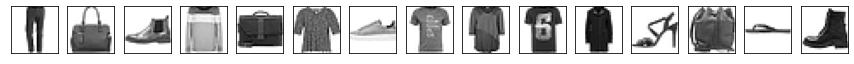

Blurred Images


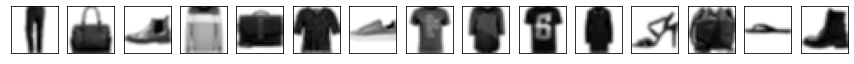

Predicted Images


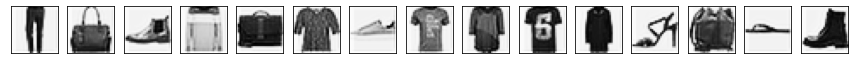

In [ ]:
plt.figure(figsize = (15, 15))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize = (15, 15))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize = (15, 15))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i], cmap=plt.cm.binary)
plt.show()